# Extract barrier island metrics along transects

Author: Emily Sturdivant, esturdivant@usgs.gov

***

Extract barrier island metrics along transects for Barrier Island Geomorphology Bayesian Network. See the project [README](https://github.com/esturdivant-usgs/BI-geomorph-extraction/blob/master/README.md) and the Methods Report (Zeigler et al., in review). 


## Pre-requisites:
- All the input layers (transects, shoreline, etc.) must be ready. This is performed with the notebook file prepper.ipynb.
- The files servars.py and configmap.py may need to be updated for the current dataset.

## Notes:
- This notebook includes interactive quality checking, which requires the user's attention. For thorough QC'ing, we recommend displaying the layers in ArcGIS, especially to confirm the integrity of values for variables such as distance to inlet (__Dist2Inlet__) and widths of the landmass (__WidthPart__, etc.). 


***

## Import modules

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import io
import arcpy
import pyproj
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import core.functions_warcpy as fwa
import core.functions as fun

In [2]:
print("Date: {}".format(datetime.date.today()))
# print(os.__version__)
# print(sys.__version__)
print('pandas version: {}'.format(pd.__version__))
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(matplotlib.__version__))
# print(io.__version__)
# print(arcpy.__version__)
print('pyproj version: {}'.format(pyproj.__version__))

# print(bi_transect_extractor.__version__)

Date: 2019-10-09
pandas version: 0.20.3
numpy version: 1.13.1
matplotlib version: 1.5.3
pyproj version: 1.9.5.1


### Initialize variables

This cell prompts you for the site, year, and project directory path. `setvars.py` retrieves the pre-determined values for that site in that year from `configmap.py`. The project directory will be used to set up your workspace. It's hidden for security – sorry! I recommend that you type the path somewhere and paste it in.

In [3]:
from core.setvars import *

site (options: Assateague, Metompkin, Cobb, Myrtle, FireIsland, Cedar, Wreck, Monomoy, ParkerRiver, Fisherman, CapeHatteras, Rockaway, CapeLookout, Assawoman, ShipShoal, Smith, CoastGuard, Forsythe, Parramore, RhodeIsland):  Myrtle
year (options: 2010, 2012, 2014):  2014
Path to project directory (e.g. \\Macolume\dir\FireIsland2014):  ···········································


setvars.py initialized variables.
SITE: Myrtle
MHW: 0.34
MLW: -0.59
Max dune crest height: 2.5
Projection code: 26918



Change the filename variables to match your local files. They should be in an Esri file geodatabase named site+year.gdb in your project directory, which you input above and is the value of the variable `home`. 

In [24]:
# Extended transects: NASC transects extended and sorted, ready to be the base geometry for processing
extendedTrans = os.path.join(home, 'extTrans')

# Tidied transects: Extended transects without overlapping transects
extTrans_tidy = os.path.join(home, 'extTrans') 

# Geomorphology points: positions of indicated geomorphic features
ShorelinePts = os.path.join(home, 'Myrtle2014_SLpts')  # shoreline
dlPts = os.path.join(home, 'Myrtle2014_DLpts')         # dune toe
dhPts = os.path.join(home, 'Myrtle2014_DHpts')         # dune crest

# Inlet lines: polyline feature classes delimiting inlet position. Must intersect the full island shoreline
inletLines = os.path.join(home, 'Myrtle2014_inletLines')

# Full island shoreline: polygon that outlines the island shoreline, MHW on oceanside and MTL on bayside
barrierBoundary = os.path.join(home, 'bndpoly_2sl_manual')  

# Elevation grid: DEM of island elevation at either 5 m or 1 m resolution
elevGrid = os.path.join(home, 'Myrtle2014_DEM')

# ---
# OPTIONAL - comment out each one that is not available
# ---
# 
# morphdata_prefix = '14CNT01'

# Study area boundary; manually digitize if the barrier island study area does not end at an inlet.
# SA_bounds = os.path.join(home, 'SA_bounds')

# Armoring lines: digitize lines of shorefront armoring to be used if dune toe points are not available.
# armorLines = os.path.join(home, 'armorLines')

# Extended transects with Construction, Development, and Nourishment coding
# tr_w_anthro = os.path.join(home, 'extTrans_wAnthro')

# Piping Plover Habitat BN raster layers
SubType = os.path.join(home, 'SubType')   # substrate type
VegType = os.path.join(home, 'VegType')   # vegetation type
VegDens = os.path.join(home, 'VegDen')    # vegetation density
GeoSet = os.path.join(home, 'GeoSet')     # geomorphic setting

# Derivatives of inputs: They will be generated during process if they are not found. 
shoreline = os.path.join(home, 'ShoreBetweenInlets')   # oceanside shoreline between inlets; generated from shoreline polygon, inlet lines, and SA bounds
slopeGrid = os.path.join(home, 'slope_5m')   # Slope at 5 m resolution; generated from DEM

## Transect-averaged values
We work with the shapefile/feature class as a pandas DataFrame as much as possible to speed processing and minimize reliance on the ArcGIS GUI display.

1. Add the bearing of each transect line to the attribute table from the LINE_BEARING geometry attribute.
1. Create a pandas dataframe from the transects feature class. In the process, remove some of the unnecessary fields. The resulting dataframe is indexed by __sort_ID__ with columns corresponding to the attribute fields in the transects feature class. 
2. Add __DD_ID__.
3. Join the values from the transect file that includes the three anthropologic development fields, __Construction__,  __Development__, and __Nourishment__. 

In [5]:
# Add BEARING field to extendedTrans feature class
print("Adding line bearing field to transects.")
arcpy.AddGeometryAttributes_management (extendedTrans, 'LINE_BEARING')

# Copy feature class to dataframe.
trans_df = fwa.FCtoDF(extendedTrans, id_fld=tID_fld, extra_fields=extra_fields)

# Set capitalization of fields to match expected
colrename = {}
for f in sorted_pt_flds:
    for c in trans_df.columns:
        if f.lower() == c.lower() and f != c:
            colrename[c] = f
            print("Renaming {} to {}".format(c, f))
trans_df.rename(columns=colrename, inplace=True)

# Set DD_ID, MHW, and Azimuth fields
trans_df['DD_ID'] = trans_df[tID_fld] + sitevals['id_init_val']
trans_df['MHW'] = sitevals['MHW']
trans_df.drop('Azimuth', axis=1, inplace=True, errors='ignore')
trans_df.rename_axis({"BEARING": "Azimuth"}, axis=1, inplace=True)

# Get anthro fields and join to DF
if 'tr_w_anthro' in locals():
    trdf_anthro = fwa.FCtoDF(tr_w_anthro, id_fld=tID_fld, dffields=['Development', 'Nourishment','Construction'])
    trans_df = fun.join_columns(trans_df, trdf_anthro) 

# Save
trans_df.to_pickle(os.path.join(scratch_dir, 'trans_df.pkl'))

# Display
print("\nHeader of transects dataframe (rows 1-5 out of {}): ".format(len(trans_df)))
trans_df.head()

Adding line bearing field to transects.
...converting feature class to array...
...converting array to dataframe...
Renaming TransectId to TRANSECTID

Header of transects dataframe (rows 1-5 out of 71): 


,OBJECTID_1,Shape,OBJECTID,BaselineID,TransOrder,ProcTime,Autogen,StartX,StartY,EndX,...,TRANSECTID,LRR,LR2,LSE,LCI90,sort_ID,Azimuth,Shape_Length,DD_ID,MHW
sort_ID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,294.764075,NaN,130001,0.34
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2,294.764075,NaN,130002,0.34
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3,294.764075,NaN,130003,0.34
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4,294.764075,NaN,130004,0.34
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5,294.764075,NaN,130005,0.34


In [6]:
# There is no development/nourishment/construction on Ship Shoal so the anthro fields receive 111 values
trans_df['Construction'] = 111
trans_df['Nourishment'] = 111
trans_df['Development'] = 111

# Save
trans_df.to_pickle(os.path.join(scratch_dir, 'trans_df.pkl'))

# Display
print("\nSample of transects dataframe ({} total): ".format(len(trans_df)))
trans_df.loc[:,['TRANSECTID', 'LRR', 'sort_ID', 'DD_ID', 'MHW', 'Construction', 'Nourishment', 'Development']].sample(10)


Sample of transects dataframe (71 total): 


,TRANSECTID,LRR,sort_ID,DD_ID,MHW,Construction,Nourishment,Development
sort_ID,,,,,,,,
55,5153.0,-3.96,55,130055,0.34,111,111,111
6,NaN,NaN,6,130006,0.34,111,111,111
46,5144.0,-5.62,46,130046,0.34,111,111,111
69,5167.0,-3.92,69,130069,0.34,111,111,111
20,NaN,NaN,20,130020,0.34,111,111,111
52,5150.0,-4.90,52,130052,0.34,111,111,111
18,NaN,NaN,18,130018,0.34,111,111,111
36,5134.0,-6.49,36,130036,0.34,111,111,111
19,NaN,NaN,19,130019,0.34,111,111,111


### Get XY and Z/slope from SL, DH, DL points within 25 m of transects
Add to each transect row the positions of the nearest pre-created beach geomorphic features (shoreline, dune toe, and dune crest).

#### If needed, convert morphology points stored locally to feature classes for use.
After which, view the new feature classes in a GIS. Isolate the points to the region of interest. Quality check them. Then copy them for use with this code, which will require setting the filenames to match those included here or changing the values included here to match the final filenames.

In [7]:
if "morphdata_prefix" in locals():
    csvpath = os.path.join(proj_dir, 'Input_Data', '{}_morphology'.format(morphdata_prefix), 
                           '{}_morphology.csv'.format(morphdata_prefix))
    dt_fc, dc_fc, sl_fc = fwa.MorphologyCSV_to_FCsByFeature(csvpath, state, proj_code, 
                                                            csv_fill = 999, fc_fill = -99999, csv_epsg=4326)
    print("OUTPUT: morphology point feature classes in the scratch gdb. We recommend QC before proceeding.")

#### Shoreline

The MHW shoreline easting and northing (__SL_x__, __SL_y__) are the coordinates of the intersection of the oceanside shoreline with the transect. Each transect is assigned the foreshore slope (__Bslope__) from the nearest shoreline point within 25 m. These values are populated for each transect as follows: 
1. get __SL_x__ and __SL_y__ at the point where the transect crosses the oceanside shoreline; 
2. find the closest shoreline point to the intersection point (must be within 25 m) and copy the slope value from the point to the transect in the field __Bslope__.

In [8]:
if not arcpy.Exists(inletLines):
    # manually create lines that correspond to end of land and cross the MHW line (refer to shoreline polygon)
    arcpy.CreateFeatureclass_management(home, os.path.basename(inletLines), 'POLYLINE', spatial_reference=utmSR)
    print("OUTPUT: {}. Interrupt execution to manually create lines at each inlet.".format(inletLines))

if not arcpy.Exists(shoreline):
    if not 'SA_bounds' in locals(): 
        SA_bounds = ''
    shoreline = fwa.CreateShoreBetweenInlets(barrierBoundary, inletLines, shoreline, ShorelinePts, proj_code, SA_bounds)

# Get the XY position where transect crosses the oceanside shoreline
sl2trans_df, ShorelinePts = fwa.add_shorelinePts2Trans(extendedTrans, ShorelinePts, shoreline, 
                                         tID_fld, proximity=pt2trans_disttolerance)

# Save and print sample
sl2trans_df.to_pickle(os.path.join(scratch_dir, 'sl2trans.pkl'))
sl2trans_df.sample(5)


Matching shoreline points to transects...
Using field 'slope' as slope.
The projection of Myrtle2014_SLpts was changed. The new file is Myrtle2014_SLpts_utm.
Duration: 0:0:28.5 seconds


,SL_x,SL_y,Bslope
sort_ID,,,
49,427565.127201,4.117046e+06,-0.004906
19,426646.944298,4.115817e+06,-0.023523
4,NaN,NaN,NaN
14,426410.553524,4.115651e+06,NaN
34,427233.492381,4.116374e+06,-0.066997


In [9]:
# Export the inlet delineation and shoreline polygons to the scratch directory ultimately for publication
arcpy.FeatureClassToFeatureClass_conversion(inletLines, scratch_dir,  pts_name.split('_')[0] + '_inletLines.shp')
arcpy.FeatureClassToFeatureClass_conversion(barrierBoundary, scratch_dir,  pts_name.split('_')[0] + '_shoreline.shp')
print('OUTPUT: Saved inletLines and shoreline shapefiles in the scratch directory.')

OUTPUT: Saved inletLines and shoreline shapefiles in the scratch directory.


In [11]:
slpts_csv = fwa.pts_to_csv_and_eainfoxml(ShorelinePts, '_SLpts', scratch_dir, pts_name, field_defs, fill)

...converting feature class to array...
...converting array to dataframe...
Number of points in dataset: (165, 11)

OBJECTID_______________________________5 | 186_________________   No fills_________No nulls
Shape............... nan
state............... 12
seg___________________________________33 | 36__________________   No fills_________No nulls
profile________________________________1 | 94__________________   No fills_________No nulls
sl_x_________________________-573.999718 | -305.391101_________   No fills_________No nulls
ci95_slx________________________0.000346 | 0.264165____________   No fills_________No nulls
slope__________________________-0.088553 | -0.004906___________   No fills_________No nulls
easting____________________426541.838151 | 427597.773927_______   No fills_________No nulls
northing__________________4115756.871306 | 4117199.927066______   No fills_________No nulls
MHW_________________________________0.34 | 0.34________________   No fills_________No nulls

OUTPUT

#### Dune positions along transects

__DL_x__, __DL_y__, and __DL_z__ are the easting, northing, and elevation, respectively, of the nearest dune toe point within 25 meters of the transect. __DH_x__, __DH_y__, and __DH_z__ are the easting, northing, and elevation, respectively, of the nearest dune crest point within 25 meters. 

__DL_snapX__, __DL_snapY__, __DH_snapX__, and __DH_snapY__ are the eastings and northings of the points "snapped" to the transect. "Snapping" finds the position along the transect nearest to the point, i.e. orthogonal to the transect. These values are used to find the beach width. The elevation values are not snapped; we use the elevation values straight from the original points. 

These values are populated as follows: 

1. Find the nearest dune crest/toe point to the transect and proceed if the distance is less than 25 m. If there are no points within 25 m of the transect, populate the row with Null values.
2. Get the X, Y, and Z values of the point. 
3. Find the position along the transect of an orthogonal line drawn to the dune point (__DL_snapX__, __DL_snapY__, __DH_snapX__, and __DH_snapY__). This is considered the 'snapped' XY position and is calculated using the arcpy geometry method. 

In [12]:
# Create dataframe for both dune crest and dune toe positions
dune2trans_df, dhPts, dlPts = fwa.find_ClosestPt2Trans_snap(extendedTrans, dhPts, dlPts, trans_df, 
                                          tID_fld, proximity=pt2trans_disttolerance)

# Save and print sample
dune2trans_df.to_pickle(os.path.join(scratch_dir, 'dune2trans.pkl'))
dune2trans_df.sample(5)


Matching dune points with transects:
Using field 'dhigh_z' as DH Z field...
The projection of Myrtle2014_DHpts was changed. The new file is Myrtle2014_DHpts_utm.
Using field 'dlow_z' as DL Z field...
The projection of Myrtle2014_DLpts was changed. The new file is Myrtle2014_DLpts_utm.
Looping through transects and dune points to find nearest point within 25 m...
Duration: 0:0:35.4 seconds


,DH_x,DH_y,DH_z,DH_snapX,DH_snapY,DL_x,DL_y,DL_z,DL_snapX,DL_snapY
sort_ID,,,,,,,,,,
44,427461.3241,4.116821e+06,1.742206,427460.507886,4.116819e+06,NaN,NaN,NaN,NaN,NaN
20,426675.5682,4.115861e+06,1.651113,426674.823060,4.115860e+06,NaN,NaN,NaN,NaN,NaN
41,427385.0563,4.116690e+06,1.789668,427384.830581,4.116689e+06,NaN,NaN,NaN,NaN,NaN
53,427384.7420,4.117373e+06,0.865180,427376.135911,4.117354e+06,NaN,NaN,NaN,NaN,NaN
17,426509.7392,4.115766e+06,1.771304,426511.456872,4.115770e+06,NaN,NaN,NaN,NaN,NaN


In [13]:
dtpts_csv = fwa.pts_to_csv_and_eainfoxml(dlPts, '_DTpts', scratch_dir, pts_name, field_defs, fill)
dcpts_csv = fwa.pts_to_csv_and_eainfoxml(dhPts, '_DCpts', scratch_dir, pts_name, field_defs, fill)

...converting feature class to array...
...converting array to dataframe...
Number of points in dataset: (32, 14)

OBJECTID_______________________________1 | 32__________________   No fills_________No nulls
Shape............... nan
state............... 12
seg___________________________________34 | 36__________________   No fills_________No nulls
profile________________________________5 | 94__________________   No fills_________No nulls
lon___________________________-75.821064 | -75.816539__________   No fills_________No nulls
lat____________________________37.190334 | 37.197438___________   No fills_________No nulls
easting____________________427126.739892 | 427534.678541_______   No fills_________No nulls
northing__________________4116302.674986 | 4117087.390241______   No fills_________No nulls
dlow_x_______________________-548.775347 | -376.100088_________   No fills_________No nulls
dlow_z__________________________1.012952 | 1.23232_____________   No fills_________No nulls
z_error_

#### Armoring
__Arm_x__, __Arm_y__, and __Arm_z__ are the easting, northing, and elevation, respectively, where an artificial structure crosses the transect in the vicinity of the beach. These features are meant to supplement the dune toe data set by providing an upper limit to the beach in areas where dune toe extraction was confounded by the presence of an artificial structure. Values are populated for each transect as follows: 

1. Get the positions of intersection between the digitized armoring lines and the transects (Intersect tool from the Overlay toolset); 
2. Extract the elevation value at each intersection point from the DEM (Extract Multi Values to Points tool from Spatial Analyst); 

In [14]:
# Create elevation raster at 5-m resolution if not already
# elevGrid = fwa.ProcessDEM_2(elevGrid, utmSR)

# Armoring line
if not arcpy.Exists(armorLines):
    arcpy.CreateFeatureclass_management(home, os.path.basename(armorLines), 'POLYLINE', spatial_reference=utmSR)
    print("{} created. If shorefront armoring exists, interrupt execution to manually digitize.".format(armorLines))

arm2trans_df = fwa.ArmorLineToTrans_PD(extendedTrans, armorLines, sl2trans_df, tID_fld, proj_code, elevGrid)

# Save and print sample
arm2trans_df.to_pickle(os.path.join(scratch_dir, 'arm2trans.pkl'))
try:
    arm2trans_df.sample(5)
except:
    pass


Armoring file either missing or empty so we will proceed without armoring data. If shorefront tampering is present at this site, cancel the operations to digitize.


### Add all the positions to the trans_df
Join the new dataframes to the transect dataframe. Before it performs the join, `join_columns_id_check()` checks the index and the ID field for potential errors such as whether they are the equal and whether there are duplicated IDs or null values in either.

In [15]:
# Load saved dataframes
trans_df = pd.read_pickle(os.path.join(scratch_dir, 'trans_df.pkl'))
sl2trans_df = pd.read_pickle(os.path.join(scratch_dir, 'sl2trans.pkl'))
dune2trans_df = pd.read_pickle(os.path.join(scratch_dir, 'dune2trans.pkl'))
arm2trans_df = pd.read_pickle(os.path.join(scratch_dir, 'arm2trans.pkl'))

In [16]:
# Join positions of shoreline, dune crest, dune toe, armoring
trans_df = fun.join_columns_id_check(trans_df, sl2trans_df, tID_fld)
trans_df = fun.join_columns_id_check(trans_df, dune2trans_df, tID_fld)
trans_df = fun.join_columns_id_check(trans_df, arm2trans_df, tID_fld)

# Save and print sample
trans_df.to_pickle(os.path.join(scratch_dir, 'trans_df_beachmetrics.pkl'))
trans_df.loc[:,['sort_ID', 'DD_ID', 'TRANSECTID', 'MHW', 'SL_x', 'Bslope', 'DH_z', 'DL_z']].sample(10)

...checking ID field(s) for df2 (join)...
...checking ID field(s) for df2 (join)...
...checking ID field(s) for df2 (join)...


,sort_ID,DD_ID,TRANSECTID,MHW,SL_x,Bslope,DH_z,DL_z
sort_ID,,,,,,,,
19,19,130019,NaN,0.34,426646.944298,-0.023523,1.607837,NaN
36,36,130036,5134.0,0.34,427271.373596,NaN,1.750140,NaN
45,45,130045,5143.0,0.34,427503.080614,-0.051097,1.741797,NaN
63,63,130063,5161.0,0.34,NaN,NaN,NaN,NaN
7,7,130007,NaN,0.34,NaN,NaN,NaN,NaN
26,26,130026,5124.0,0.34,426951.676973,-0.056549,1.619417,NaN
66,66,130066,5164.0,0.34,NaN,NaN,NaN,NaN
47,47,130047,5145.0,0.34,427529.335143,-0.054899,1.796475,1.139943
61,61,130061,5159.0,0.34,NaN,NaN,1.437235,NaN


### Check for errors
*Optional*

Display summary stats / histograms and create feature classes. The feature classes display the locations that will be used to calculate beach width. Review the output feature classes in a GIS to validate. 

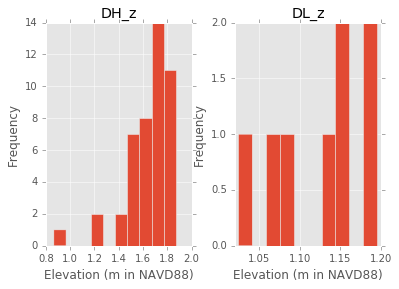

In [17]:
plots = trans_df.hist(['DH_z', 'DL_z', 'Arm_z'])

# Subplot Labels
plots[0][0].set_xlabel("Elevation (m in NAVD88)")
plots[0][0].set_ylabel("Frequency")
plots[0][1].set_xlabel("Elevation (m in NAVD88)")
plots[0][1].set_ylabel("Frequency")
try:
    plots[0][2].set_xlabel("Elevation (m in NAVD88)")
    plots[0][2].set_ylabel("Frequency")
except:
    pass

plt.show()
plt.close()

In [18]:
# Convert dataframe to feature class - shoreline points with slope
fwa.DFtoFC(sl2trans_df, os.path.join(arcpy.env.workspace, 'pts2trans_SL'), 
           spatial_ref=utmSR, id_fld=tID_fld, xy=["SL_x", "SL_y"], keep_fields=['Bslope'])
print('OUTPUT: pts2trans_SL in designated scratch geodatabase.')

# Dune crests
try:
    fwa.DFtoFC(dune2trans_df, os.path.join(arcpy.env.workspace, 'ptSnap2trans_DH'), 
               spatial_ref=utmSR, id_fld=tID_fld, xy=["DH_snapX", "DH_snapY"], keep_fields=['DH_z'])
    print('OUTPUT: ptSnap2trans_DH in designated scratch geodatabase.')
except Exception as err:
    print(err)
    pass

# Dune toes
try:
    fwa.DFtoFC(dune2trans_df, os.path.join(arcpy.env.workspace, 'ptSnap2trans_DL'), 
               spatial_ref=utmSR, id_fld=tID_fld, xy=["DL_snapX", "DL_snapY"], keep_fields=['DL_z'])
    print('OUTPUT: ptSnap2trans_DL in designated scratch geodatabase.')
except Exception as err:
    print(err)
    pass

... converting dataframe to array... 
... converting array to feature class... 

OUTPUT: pts2trans_SL in designated scratch geodatabase.
... converting dataframe to array... 
... converting array to feature class... 

OUTPUT: ptSnap2trans_DH in designated scratch geodatabase.
... converting dataframe to array... 
... converting array to feature class... 

OUTPUT: ptSnap2trans_DL in designated scratch geodatabase.


### Calculate upper beach width and height
Upper beach width (__uBW__) and upper beach height (__uBH__) are calculated based on the difference in position between two points: the position of MHW along the transect (__SL_x__, __SL_y__) and the dune toe position or equivalent (usually __DL_snapX__, __DL_snapY__).  In some cases, the dune toe is not appropriate to designate the "top of beach" so beach width and height are calculated from either the position of the dune toe, the dune crest, or the base of an armoring structure. The dune crest was only considered a possibility if the dune crest elevation (__DH_zMHW__) was less than or equal to `maxDH`. 

They are calculated as follows: 
2. Calculate distances from MHW to the position along the transect of the dune toe (__DistDL__), dune crest (__DistDH__), and armoring (__DistArm__). 
2. Adjust the elevations to MHW, populating fields __DH_zmhw__, __DL_zmhw__, and __Arm_zmhw__. 
3. Conditionally select the appropriate feature to represent "top of beach." Dune toe is prioritized. If it is not available and __DH_zmhw__ is less than or equal to maxDH, use dune crest. If neither of the dune positions satisfy the conditions and an armoring feature intersects with the transect, use the armoring position. If none of the three are possible, __uBW__ and __uBH__ will be null. 
4. Copy the distance to shoreline and height above MHW (__Dist--__, __---zmhw__) to __uBW__ and __uBH__, respectively. 

Notes:
- In some morphology datasets, missing elevation values at a point indicate that the point should not be used to measure beach width. In those cases, use the `skip_missing_z` argument to select whether or not to skip these points. 

In [19]:
# Load saved dataframe
trans_df = pd.read_pickle(os.path.join(scratch_dir, 'trans_df_beachmetrics.pkl'))

In [20]:
# Calculate distances from shore to dunes, etc.
trans_df  = fwa.calc_BeachWidth_fill(extendedTrans, trans_df, maxDH, tID_fld, 
                                     sitevals['MHW'], fill, skip_missing_z=True)

...checking ID field(s) for df2 (join)...
Fields uBW and uBH populated with beach width and beach height.


### Dist2Inlet


Distance to nearest tidal inlet (__Dist2Inlet__) is computed as alongshore distance of each sampling transect from the nearest tidal inlet. This distance includes changes in the path of the shoreline instead of simply a Euclidean distance and reflects sediment transport pathways. It is measured using the oceanside shoreline between inlets (ShoreBetweenInlets). 

Note that the ShoreBetweenInlets feature class must be both 'dissolved' and 'singlepart' so that each feature represents one-and-only-one shoreline that runs the entire distance between two inlets or equivalent. If the shoreline is bounded on both sides by an inlet, measure the distance to both and assign the minimum distance of the two. If the shoreline meets only one inlet (meaning the study area ends before the island ends), use the distance to the only inlet. 

The process uses the cut, disjoint, and length geometry methods and properties in ArcPy data access module. The function measure_Dist2Inlet() prints a warning when the difference in Dist2Inlet between two consecutive transects is greater than 300. 

In [21]:
# Calc Dist2Inlet in new dataframe 
dist_df = fwa.measure_Dist2Inlet(shoreline, extendedTrans, inletLines, tID_fld)

# Join to transects
trans_df = fun.join_columns_id_check(trans_df, pd.DataFrame(dist_df.Dist2Inlet), tID_fld, fill=fill)

# Save and view last 10 rows
dist_df.to_pickle(os.path.join(scratch_dir, 'dist2inlet_df.pkl'))
dist_df.tail(10)

Duration: 0:0:1.3 seconds
...checking ID field(s) for df2 (join)...


,Dist2Inlet,lenL,lenR
sort_ID,,,
42.0,566.925233,566.925233,1757.514875
43.0,516.428650,516.428650,1808.011458
44.0,465.155959,465.155959,1859.284149
45.0,414.996559,414.996559,1909.443548
46.0,362.772418,362.772418,1961.667690
47.0,312.476027,312.476027,2011.964081
48.0,261.998770,261.998770,2062.441338
49.0,208.080318,208.080318,2116.359790
50.0,133.788553,133.788553,2190.651554


### Clip transects, get barrier widths
Calculates __WidthLand__, __WidthFull__, and __WidthPart__, which measure different flavors of the cross-shore width of the barrier island. __WidthLand__ is the above-water distance between the back-barrier and seaward MHW shorelines. __WidthLand__ only includes regions of the barrier within the shoreline polygon (bndpoly_2sl) and does not extend into any of the sinuous or intervening back-barrier waterways and islands. __WidthFull__ is the total distance between the back-barrier and seaward MHW shorelines (including space occupied by waterways). __WidthPart__ is the width of only the most seaward portion of land within the shoreline. 

These are calculated as follows: 

1. Clip the transect to the full island shoreline (Clip in the Analysis toolbox); 
2. For __WidthLand__, get the length of the multipart line segment from &quot;SHAPE@LENGTH&quot; feature class attribute. When the feature is multipart, this will include only the remaining portions of the transect; 
3. For __WidthPart__, convert the clipped transect from multipart to singlepart and get the length of the first line segment, which should be the most seaward; 
4. For __WidthFull__, calculate the distance between the first vertex and the last vertex of the clipped transect (Feature Class to NumPy Array with explode to points, pandas groupby, numpy hypot).

In [22]:
# Clip transects, get barrier widths
widths_df = fwa.calc_IslandWidths(extendedTrans, barrierBoundary, tID_fld=tID_fld)

# # Save
widths_df.to_pickle(os.path.join(scratch_dir, 'widths_df.pkl'))

# Join
trans_df = fun.join_columns_id_check(trans_df, widths_df, tID_fld, fill=fill)

# Save
trans_df.to_pickle(os.path.join(scratch_dir, trans_name+'_null_prePts.pkl'))
trans_df.loc[:,['sort_ID', 'WidthLand', 'WidthPart', 'WidthFull', 'Dist2Inlet', 'uBW']].sample(10)

Clipping the transects to the barrier island boundaries ('clip2island')...
Getting the width along each transect of the oceanside land (WidthPart)...
...converting feature class to array...
...converting array to dataframe...
Getting the width along each transect of the entire barrier (WidthFull)...
Converting feature class vertices to array with X and Y...
...converting array to dataframe...
Getting the width along each transect of above water portion of the barrier (WidthLand)...
...checking ID field(s) for df2 (join)...


,sort_ID,WidthLand,WidthPart,WidthFull,Dist2Inlet,uBW
sort_ID,,,,,,
4,4,1632.859309,90.348175,1809.787719,NaN,NaN
58,58,610.348810,610.348810,610.348810,NaN,NaN
21,21,1809.429155,1809.429155,1809.429155,657.403151,70.948320
60,60,428.073165,428.073165,428.073165,NaN,NaN
63,63,127.958634,127.958634,127.958634,NaN,NaN
13,13,1504.913941,442.857727,1614.735928,161.777012,NaN
47,47,1234.439831,561.074045,1274.511583,312.476027,13.240498
8,8,1718.791946,184.984090,2037.651607,NaN,NaN
71,71,NaN,NaN,NaN,NaN,NaN


## 5-m Points
The point dataset samples the land every 5 m along each shore-normal transect. 

### Split transects into points at 5-m intervals. 

The point dataset is created from the tidied transects (tidyTrans, created during pre-processing) as follows: 

1. Clip the tidied transects (tidyTrans) to the shoreline polygon (bndpoly_2sl) , retaining only those portions of the transects that represent land.
2. Produce a dataframe of point positions along each transect every 5 m starting from the ocean-side shoreline. This uses the positionAlongLine geometry method accessed with a Search Cursor and saves the outputs in a new dataframe. 
3. Create a point feature class from the dataframe. 

Note: Sometimes the system doesn't seem to register the new feature class (transPts_unsorted) for a while. I'm not sure how to work around that, other than just to wait. 

In [25]:
pts_df, pts_presort = fwa.TransectsToPointsDF(extTrans_tidy, barrierBoundary, fc_out=pts_presort)
print("OUTPUT: '{}' in scratch geodatabase.".format(os.path.basename(pts_presort)))

# Save
pts_df.to_pickle(os.path.join(scratch_dir, 'pts_presort.pkl'))

Clipping transects to within the shoreline bounds ('tidytrans_clipped')...
Getting points every 5m along each transect and saving in new dataframe...
Converting dataframe to feature class ('transPts_unsorted')...
... converting dataframe to array... 
... converting array to feature class... 

Duration: 0:0:47.0 seconds
OUTPUT: 'transPts_unsorted' in scratch geodatabase.


### Add Elevation and Slope to points

__ptZ__ (later __ptZmhw__) and __ptSlp__ are the elevation and slope at the 5-m cell corresponding to the point. 
1. Create the slope and DEM rasters if they don't already exist. We use the 5-m DEM to generate a slope surface (Slope tool in 3D Analyst). 
2. Use Extract Multi Values to Points tool in Spatial Analyst. 
3. Convert the feature class back to a dataframe.

In [26]:
# Create slope raster from DEM
if not arcpy.Exists(slopeGrid):
    arcpy.Slope_3d(elevGrid, slopeGrid, 'PERCENT_RISE')
    print("OUTPUT: slope file in designated home geodatabase.")
    
# Add elevation and slope values at points.
arcpy.sa.ExtractMultiValuesToPoints(pts_presort, [[elevGrid, 'ptZ'], [slopeGrid, 'ptSlp']])
print("OUTPUT: added slope and elevation to '{}' in designated scratch geodatabase.".format(os.path.basename(pts_presort)))

OUTPUT: added slope and elevation to 'transPts_unsorted' in designated scratch geodatabase.


In [27]:
if 'SubType' in locals():
    # Add substrate type, geomorphic setting, veg type, veg density values at points.
    arcpy.sa.ExtractMultiValuesToPoints(pts_presort, [[SubType, 'SubType'], [VegType, 'VegType'], 
                                                           [VegDens, 'VegDens'], [GeoSet, 'GeoSet']])

    # Convert to dataframe
    pts_df = fwa.FCtoDF(pts_presort, xy=True, dffields=[tID_fld,'ptZ', 'ptSlp', 'SubType', 
                                                             'VegType', 'VegDens', 'GeoSet'])
    # Recode fill values
    pts_df.replace({'GeoSet': {9999:np.nan}, 'SubType': {9999:np.nan}, 'VegType': {9999:np.nan},
                    'VegDens': {9999:np.nan}}, inplace=True)
else:
    print("Plover BN layers not specified (we only check for SubType), so we'll proceed without them. ")
    # Convert to dataframe
    pts_df = fwa.FCtoDF(pts_presort, xy=True, dffields=[tID_fld,'ptZ', 'ptSlp'])

# Convert new fields to appropriate types
pts_df = pts_df.astype({'ptZ':'float64', 'ptSlp':'float64'})

# Save and view sample
pts_df.to_pickle(os.path.join(scratch_dir, 'pts_extractedvalues_presort.pkl'))
pts_df.loc[:,['SplitSort', 'DD_ID', 'TRANSECTID', 'GeoSet', 'SubType', 'VegType', 'VegDens', 'ptZ', 'ptSlp']].sample(10)

Converting feature class to array with X and Y...
...converting array to dataframe...


,SplitSort,DD_ID,TRANSECTID,GeoSet,SubType,VegType,VegDens,ptZ,ptSlp
7396,NaN,NaN,NaN,6.0,3333.0,NaN,NaN,-0.851603,17.059950
17224,NaN,NaN,NaN,6.0,3333.0,NaN,NaN,0.323222,0.159739
14932,NaN,NaN,NaN,6.0,4444.0,11.0,111.0,-0.067738,12.234864
3075,NaN,NaN,NaN,6.0,3333.0,NaN,NaN,-0.068343,1.104658
2482,NaN,NaN,NaN,6.0,3333.0,NaN,NaN,0.178847,0.299896
10405,NaN,NaN,NaN,6.0,3333.0,NaN,NaN,0.334414,2.412971
8294,NaN,NaN,NaN,6.0,3333.0,NaN,NaN,0.437995,0.412721
7234,NaN,NaN,NaN,6.0,3333.0,NaN,NaN,0.291927,3.401566
7165,NaN,NaN,NaN,6.0,3333.0,NaN,NaN,0.357934,1.821295
12956,NaN,NaN,NaN,6.0,3333.0,NaN,NaN,0.472638,0.223842


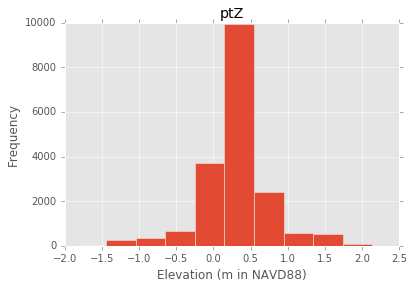

In [28]:
# Print histogram of elevation extracted to points
plots = pts_df.hist('ptZ')

# Subplot Labels
plots[0][0].set_xlabel("Elevation (m in NAVD88)")
plots[0][0].set_ylabel("Frequency")

# Display
plt.show()
plt.close()

### Calculate distances and sort points

__SplitSort__ is a unique numeric identifier of the 5-m points at the study site, sorted by order along shoreline and by distance from oceanside. __SplitSort__ values are populated by sorting the points by __sort_ID__ and __Dist_Seg__ (see below). 

__Dist_Seg__ is the Euclidean distance between the point and the seaward shoreline (__SL_x__, __SL_y__). __Dist_MHWbay__ is the distance between the point and the bayside shoreline and is calculated by subtracting the __Dist_Seg__ value from the __WidthPart__ value of the transect. 

__DistSegDH__, __DistSegDL__, and __DistSegArm__ measure the distance of each 5-m point from the dune crest and dune toe position along a particular transect. They are calculated as the Euclidean distance between the 5-m point and the given feature. 

In [29]:
# Load saved dataframes
pts_df = pd.read_pickle(os.path.join(scratch_dir, 'pts_extractedvalues_presort.pkl'))
trans_df = pd.read_pickle(os.path.join(scratch_dir, trans_name+'_null_prePts.pkl'))

In [30]:
# Calculate DistSeg, Dist_MHWbay, DistSegDH, DistSegDL, DistSegArm, and sort points (SplitSort)
pts_df = fun.join_columns(pts_df, trans_df, tID_fld)
pts_df = fun.prep_points(pts_df, tID_fld, pID_fld, sitevals['MHW'], fill)

# Aggregate ptZmhw to max and mean and join to transects
pts_df, zmhw = fun.aggregate_z(pts_df, sitevals['MHW'], tID_fld, 'ptZ', fill)
trans_df = fun.join_columns(trans_df, zmhw) 

# Join transect values to pts
pts_df = fun.join_columns(pts_df, trans_df, tID_fld)

# pID_fld needs to be among the columns
if not pID_fld in pts_df.columns:
    pts_df.reset_index(drop=False, inplace=True)

# Match field names to those in sorted_pt_flds list
for fld in pts_df.columns:
    if fld not in sorted_pt_flds:
        for i, fldi in enumerate(sorted_pt_flds):
            if fldi.lower() == fld.lower():
                sorted_pt_flds[i] = fld   
                print(fld)
    
# Drop extra fields and sort columns
trans_df.drop(extra_fields, axis=1, inplace=True, errors='ignore')
for i, f in enumerate(sorted_pt_flds):
    for c in pts_df.columns:
        if f.lower() == c.lower():
            sorted_pt_flds[i] = c
pts_df = pts_df.reindex_axis(sorted_pt_flds, axis=1)

# convert projected coordinates to geographic coordinates (lat, lon in NAD83)
pts_df = fun.add_latlon(pts_df, proj_code)

# Save dataframes 
trans_df.to_pickle(os.path.join(scratch_dir, trans_name+'_null.pkl'))
pts_df.to_pickle(os.path.join(scratch_dir, pts_name+'_null.pkl'))

# View random rows from the points DF
pts_df.loc[:,['SplitSort', 'seg_x', 'SubType', 'ptZmhw', 'sort_ID', 'Dist_Seg', 'mean_Zmhw']].sample(10)

,SplitSort,seg_x,SubType,ptZmhw,sort_ID,Dist_Seg,mean_Zmhw
13882,13882,426828.949297,3333.0,-0.054015,39.0,565.000000,-0.014358
3539,3539,425559.560694,4444.0,-1.378710,11.0,785.000000,0.007363
9470,9470,426822.200134,3333.0,0.042504,28.0,200.000000,-0.122726
6806,6806,426427.389622,3333.0,-0.082777,21.0,385.000000,0.007393
5269,5269,425587.479476,3333.0,0.316055,16.0,1000.000000,0.016467
16016,16016,427024.829068,3333.0,0.081538,46.0,535.000000,-0.044033
17273,17273,426668.490897,3333.0,0.209865,51.0,956.840895,0.259274
14541,14541,427003.173558,3333.0,0.436905,41.0,440.000000,-0.004422
13009,13009,425627.820655,3333.0,-0.019437,36.0,1810.000000,-0.143672
15939,15939,427374.424583,3333.0,-0.096225,46.0,150.000000,-0.044033


### Change number of significant digits

- Elevations: 2 significant digits 
- Lengths: 1
- UTM coords: 2
- lat longs: 6
- LRR: 2

Would be nice if fill value was always integer (not -99999.0 etc.)

In [31]:
# Replace NaNs with fill value
pts_df.fillna(fill, inplace=True) 

# Round fields to given significant digits
fprecision = {# UTM coordinates
            'seg_x':2, 'seg_y':2, 'SL_x':2, 'SL_y':2, 'DL_x':2, 'DL_y':2,
            'DH_x':2, 'DH_y':2, 'DL_snapX':2, 'DL_snapY':2, 'DH_snapX':2, 'DH_snapY':2, 
            'Arm_x':2, 'Arm_y':2,
            # Geographic coordinates
            'seg_lon':6, 'seg_lat':6,
            # Elevations
            'ptZ':2, 'ptZmhw':2, 'DL_z':2, 'DL_zmhw':2, 'DH_z':2, 'DH_zmhw':2, 
            'Arm_z':2, 'Arm_zmhw':2, 'uBH':2, 'mean_Zmhw':2, 'max_Zmhw':2,
            # Lengths
            'Dist_Seg':1, 'Dist_MHWbay':1, 'DistSegDH':1, 'DistSegDL':1, 'DistSegArm':1, 'DistDH':1, 
            'DistDL':1, 'DistArm':1,'Dist2Inlet':1, 'WidthPart':1, 'WidthLand':1, 'WidthFull':1, 'uBW':1,
            # LRR
            'LRR':2,
            # IDs
            'SplitSort':0, 'sort_ID':0, 'TRANSECTID':0, 'DD_ID':0,
            # Other
            'Azimuth':1,'Bslope':4,'ptSlp':4}
pts_df = pts_df.round(fprecision)

# # Set GeoSet, SubType, VegDens, VegType fields to int32 dtypes
pts_df = pts_df.astype({'GeoSet':'int32', 'SubType':'int32', 'VegDens':'int32', 'VegType':'int32', 
                        'Construction':'int32', 'Development':'int32', 'Nourishment':'int32', 
                        'sort_ID':'int32', 'DD_ID':'int32', 'TRANSECTID':'int32'})

# Recode
pts_df.to_pickle(os.path.join(scratch_dir, pts_name+'_fill_ints.pkl'))

# View random rows from the points DF
pts_df.loc[:,['SplitSort', 'sort_ID', 'seg_y', 'VegType', 'ptSlp', 'Dist_Seg', 'max_Zmhw', 'Development', 'TRANSECTID']].sample(10)

,SplitSort,sort_ID,seg_y,VegType,ptSlp,Dist_Seg,max_Zmhw,Development,TRANSECTID
250,250,1,4115558.12,-99999,0.8290,-99999.0,0.57,111,-99999
12972,12972,36,4117146.85,-99999,0.4748,1625.0,1.61,111,5134
6067,6067,19,4115867.63,11,2.0618,120.0,1.31,111,-99999
16905,16905,50,4117158.81,77,0.5620,155.0,1.23,111,5148
4029,4029,12,4116079.42,-99999,1.3627,1180.0,1.58,111,-99999
16374,16374,47,4117394.82,-99999,1.4689,1055.1,1.55,111,5145
9849,9849,29,4116215.08,77,0.8542,60.0,1.40,111,5127
2468,2468,8,4115854.39,11,0.3751,-99999.0,1.11,111,-99999
8195,8195,24,4116734.92,-99999,0.5436,1800.0,1.41,111,5122
11749,11749,33,4116951.29,-99999,0.9956,1461.2,1.59,111,5131


### Recode the values for CSV output and model running

In [32]:
# Recode
pts_df4csv = pts_df.replace({'SubType': {7777:'{1111, 2222}', 1000:'{1111, 3333}'}, 
                              'VegType': {77:'{11, 22}', 88:'{22, 33}', 99:'{33, 44}'},
                              'VegDens': {666: '{111, 222}', 777: '{222, 333}', 
                                          888: '{333, 444}', 999: '{222, 333, 444}'}})

# Save and view sample
pts_df4csv.to_pickle(os.path.join(scratch_dir, pts_name+'_csv.pkl'))
pts_df.loc[:,['SplitSort', 'sort_ID', 'VegType', 'SubType', 'VegDens', 'GeoType']].sample(10)

,SplitSort,sort_ID,VegType,SubType,VegDens,GeoType
10162,10162,29,-99999,3333,-99999,NaN
15113,15113,43,-99999,3333,-99999,NaN
10021,10021,29,-99999,3333,-99999,NaN
16755,16755,49,-99999,3333,-99999,NaN
11835,11835,33,-99999,3333,-99999,NaN
9996,9996,29,-99999,3333,-99999,NaN
9908,9908,29,-99999,3333,-99999,NaN
16205,16205,47,-99999,3333,-99999,NaN
1607,1607,6,-99999,3333,-99999,NaN
9220,9220,27,-99999,3333,-99999,NaN


In [33]:
# Replace fills with Nulls
pts_df = pts_df.replace(fill, np.nan)
pts_df.to_pickle(os.path.join(scratch_dir, pts_name+'_null.pkl'))

## Quality checking
Look at extracted profiles from around the island. Enter the transect ID within the available range when prompted. Evaluate the plots for consistency among variables. Repeat various times until you can be satisfied that the variables are consistent with each other and appear to represent reality. View areas with inconsistencies in a GIS.

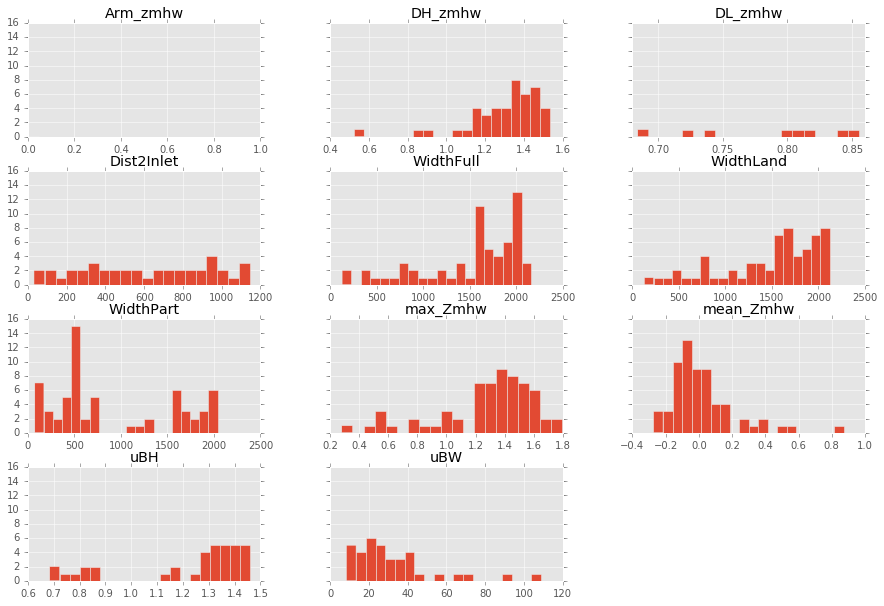

In [34]:
desccols = ['DL_zmhw', 'DH_zmhw', 'Arm_zmhw', 'uBW', 'uBH', 'Dist2Inlet', 
            'WidthPart', 'WidthLand', 'WidthFull', 'mean_Zmhw', 'max_Zmhw']

# Histograms
trans_df.hist(desccols, sharey=True, figsize=[15, 10], bins=20)
plt.show()
plt.close('all')

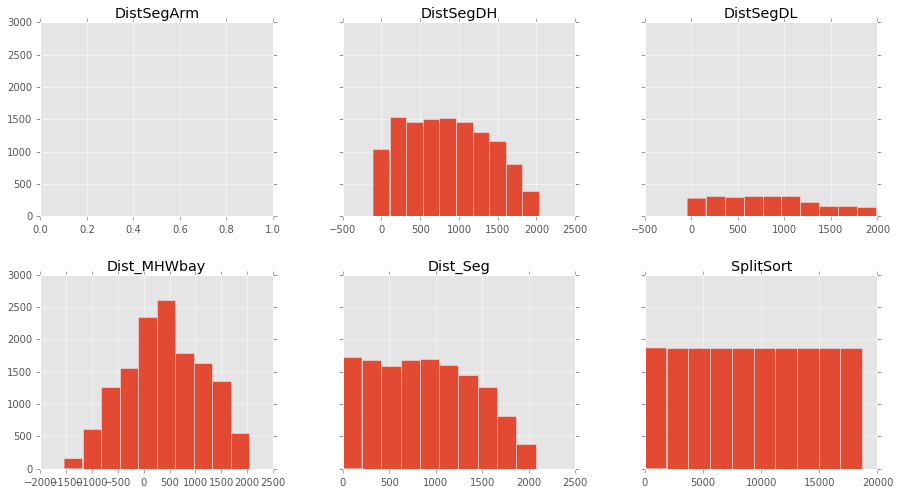

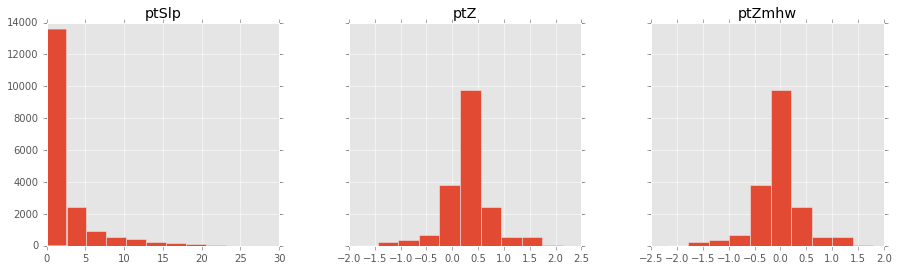

In [35]:
flds_dist = ['SplitSort', 'Dist_Seg', 'Dist_MHWbay', 'DistSegDH', 'DistSegDL', 'DistSegArm']
flds_z = ['ptZmhw', 'ptZ', 'ptSlp']
pts_df.loc[:,flds_dist+flds_z].describe()
pts_df.hist(flds_dist, sharey=True, figsize=[15, 8], layout=(2,3))
pts_df.hist(flds_z, sharey=True, figsize=[15, 4], layout=(1,3))

plt.show()
plt.close('all')

Transect ID ("sort_ID" 1-71):  25


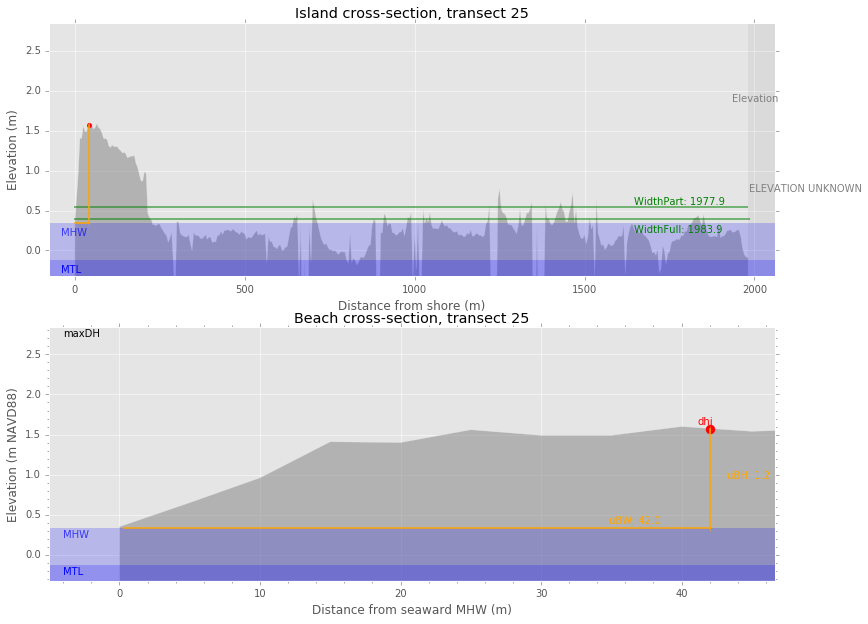

In [36]:
# Prompt for transect identifier (sort_ID) and get all points from that transect.
trans_in = int(input('Transect ID ("sort_ID" {:d}-{:d}): '.format(int(pts_df[tID_fld].head(1)), int(pts_df[tID_fld].tail(1)))))
pts_set = pts_df[pts_df[tID_fld] == trans_in]

# Plot
fig = plt.figure(figsize=(13,10))

# Plot the width of the island.
ax1 = fig.add_subplot(211)
try:
    fun.plot_island_profile(ax1, pts_set, sitevals['MHW'], sitevals['MTL'])
except TypeError as err:
    print('TypeError: {}'.format(err))
    pass

# Zoom in on the upper beach.
ax2 = fig.add_subplot(212)
try:
    fun.plot_beach_profile(ax2, pts_set, sitevals['MHW'], sitevals['MTL'], maxDH)
except TypeError as err:
    print('TypeError: {}'.format(err))
    pass 

# Display
plt.show()
plt.close('all')

### Report field values

In [37]:
# Load dataframe
pts_df4csv = pd.read_pickle(os.path.join(scratch_dir, pts_name+'_csv.pkl'))

In [38]:
xmlfile = os.path.join(scratch_dir, pts_name+'_eainfo.xml')
fun.report_fc_values(pts_df4csv, field_defs, xmlfile)

Number of points in dataset: (18681, 56)

SplitSort______________________________0 | 18680_______________   No fills_________No nulls
seg_x__________________________423997.27 | 427591.09___________   Fills present____No nulls
seg_y_________________________4115396.85 | 4117965.87__________   Fills present____No nulls
seg_lon_______________________-75.856295 | -75.815941__________   Fills present____No nulls
seg_lat________________________37.182034 | 37.205334___________   Fills present____No nulls
Dist_Seg_____________________________0.0 | 2074.3______________   Fills present____No nulls
Dist_MHWbay______________________-1542.4 | 2038.6______________   Fills present____No nulls
DistSegDH_________________________-108.8 | 2032.3______________   Fills present____No nulls
DistSegDL__________________________-46.3 | 1981.1______________   Fills present____No nulls
DistSegArm________________________-99999 | -99999______________   ONLY Fills_______No nulls
ptZ________________________________-1.

[]

## Outputs

### Transect-averaged
Output the transect-averaged metrics in the following formats:
- transects, unpopulated except for ID values, as gdb feature class
- transects, unpopulated except for ID values, as shapefile
- populated transects with fill values as gdb feature class
- populated transects with null values as gdb feature class
- populated transects with fill values as shapefile
- raster of beach width (__uBW__) by transect

In [39]:
# Load the dataframe
trans_df = pd.read_pickle(os.path.join(scratch_dir, trans_name+'_null.pkl'))

#### Vector format

In [41]:
# Create transect file with only ID values and geometry to publish.
for i, f in enumerate(trans_flds):
    for c in trans_df.columns:
        if f.lower() == c.lower():
            trans_flds[i] = c
            
trans_4pub = fwa.JoinDFtoFC(trans_df.loc[:,trans_flds], extendedTrans, tID_fld, out_fc=sitevals['code']+'_trans2')
out_shp = arcpy.FeatureClassToFeatureClass_conversion(trans_4pub, scratch_dir, sitevals['code']+'_trans.shp')
print("OUTPUT: {} in specified scratch_dir.".format(os.path.basename(str(out_shp))))

Created myr_trans2 from input dataframe and extTrans file.
OUTPUT: myr_trans.shp in specified scratch_dir.


In [42]:
trans_4pubdf = fwa.FCtoDF(trans_4pub)
xmlfile = os.path.join(scratch_dir, trans_4pub + '_eainfo.xml')
trans_df_extra_flds = fun.report_fc_values(trans_4pubdf, field_defs, xmlfile)

...converting feature class to array...
...converting array to dataframe...
Number of points in dataset: (71, 7)

Shape............... nan
sort_ID________________________________1 | 71__________________   No fills_________No nulls
Shape_Length___________3441.292285120684 | 4800.00000064161____   No fills_________No nulls
TRANSECTID________________________5119.0 | 5169.0______________   No fills_______Nulls present
DD_ID_____________________________130001 | 130071______________   No fills_________No nulls
MHW_________________________________0.34 | 0.34________________   No fills_________No nulls



In [43]:
# Create transect FC with fill values - Join values from trans_df to the transect FC as a new file.
trans_fc = fwa.JoinDFtoFC_2(trans_df, extendedTrans, tID_fld, out_fc=trans_name+'_fill')

# Create transect FC with null values
fwa.CopyFCandReplaceValues(trans_fc, fill, None, out_fc=trans_name+'_null', out_dir=home)

# Save final transect SHP with fill values
out_shp = arcpy.FeatureClassToFeatureClass_conversion(trans_fc, scratch_dir, trans_name+'_shp.shp')
print("OUTPUT: {} in specified scratch_dir.".format(os.path.basename(str(out_shp))))

Created myr14_trans_fill from input dataframe and extTrans file.
OUTPUT: myr14_trans_null
OUTPUT: myr14_trans_shp.shp in specified scratch_dir.


#### Raster - beach width
It may be necessary to close any Arc sessions you have open.

In [44]:
# Create a template raster corresponding to the transects. 
if not arcpy.Exists(rst_transID):
    print("{} was not found so we will create the base raster.".format(os.path.basename(rst_transID)))
    outEucAll = arcpy.sa.EucAllocation(extTrans_tidy, maximum_distance=50, cell_size=cell_size, source_field=tID_fld)
    outEucAll.save(os.path.basename(rst_transID))

# Create raster of uBW values by joining trans_df to the template raster.
out_rst = fwa.JoinDFtoRaster(trans_df, os.path.basename(rst_transID), bw_rst, fill, tID_fld, 'uBW')

OUTPUT: myr14_ubw_try2. Field "Value" is ID and "uBW" is beachwidth.


### 5-m points

Output the point metrics in the following formats:
- tabular, in CSV
- populated points with fill values as gdb feature class
- populated points with null values as gdb feature class
- populated points with fill values as shapefile

In [45]:
# Load the saved dataframes
pts_df4csv = pd.read_pickle(os.path.join(scratch_dir, pts_name+'_csv.pkl'))
pts_df = pd.read_pickle(os.path.join(scratch_dir, pts_name+'_null.pkl'))

#### Tabular format

In [46]:
# Save CSV in scratch_dir
csv_fname = os.path.join(scratch_dir, pts_name +'.csv')
pts_df4csv.to_csv(csv_fname, na_rep=fill, index=False)

sz_mb = os.stat(csv_fname).st_size/(1024.0 * 1024.0)
print("\nOUTPUT: {} (size: {:.2f} MB) in specified scratch_dir.".format(os.path.basename(csv_fname), sz_mb))


OUTPUT: myr14_pts.csv (size: 7.40 MB) in specified scratch_dir.


#### Vector format

In [47]:
# Convert pts_df to FC - automatically converts NaNs to fills (default fill is -99999)
pts_fc = fwa.DFtoFC_large(pts_df, out_fc=os.path.join(arcpy.env.workspace, pts_name+'_fill'), 
                          spatial_ref=utmSR, df_id=pID_fld, xy=["seg_x", "seg_y"])

# Save final FCs with null values
fwa.CopyFCandReplaceValues(pts_fc, fill, None, out_fc=pts_name+'_null', out_dir=home)

# Save final points as SHP with fill values
out_pts_shp = arcpy.FeatureClassToFeatureClass_conversion(pts_fc, scratch_dir, pts_name+'_shp.shp')
print("OUTPUT: {} in specified scratch_dir.".format(os.path.basename(str(out_pts_shp))))

Converting points DF to FC...
... converting dataframe to array... 
... converting array to feature class... 

OUTPUT: myr14_pts_fill
Duration: 0:1:60.0 seconds
OUTPUT: myr14_pts_null
OUTPUT: myr14_pts_shp.shp in specified scratch_dir.
